## Problem Statement

Recruiting and retaining drivers is seen by industry watchers as a tough battle for Ola. Churn among drivers is high and it’s very easy for drivers to stop working for the service on the fly or jump to Uber depending on the rates.

As the companies get bigger, the high churn could become a bigger problem. To find new drivers, Ola is casting a wide net, including people who don’t have cars for jobs. But this acquisition is really costly. Losing drivers frequently impacts the morale of the organization and acquiring new drivers is more expensive than retaining existing ones.

You are working as a data scientist with the Analytics Department of Ola, focused on driver team attrition. You are provided with the monthly information for a segment of drivers for 2019 and 2020 and tasked to predict whether a driver will be leaving the company or not based on their attributes like

- Demographics (city, age, gender etc.)
- Tenure information (joining date, Last Date)
- Historical data regarding the performance of the driver (Quarterly rating, Monthly business acquired, grade, Income)

### Column Profiling:

- MMMM-YY : Reporting Date (Monthly)
- Driver_ID : Unique id for drivers
- Age : Age of the driver
- Gender : Gender of the driver – Male : 0, Female: 1
- City : City Code of the driver
- Education_Level : Education level – 0 for 10+ ,1 for 12+ ,2 for graduate
- Income : Monthly average Income of the driver
- Date Of Joining : Joining date for the driver
- LastWorkingDate : Last date of working for the driver
- Joining Designation : Designation of the driver at the time of joining
- Grade : Grade of the driver at the time of reporting
- Total Business Value : The total business value acquired by the driver in a month (negative business indicates cancellation/refund or car EMI adjustments)
- Quarterly Rating : Quarterly rating of the driver: 1,2,3,4,5 (higher is better)

In [7]:
#Importing the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score,roc_curve
import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv('https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/002/492/original/ola_driver_scaler.csv')
df.head()

,Unnamed: 0,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,0,01/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,1,02/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2
2,2,03/01/19,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2
3,3,11/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
4,4,12/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1


In [3]:
#Dropping the first column and checking the first 15 rows.
df=df.iloc[:,1:]
df.head(15)

,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,01/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,02/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2
2,03/01/19,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2
3,11/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
4,12/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
5,12/01/19,4,43.0,0.0,C13,2,65603,12/07/19,NaN,2,2,0,1
6,01/01/20,4,43.0,0.0,C13,2,65603,12/07/19,NaN,2,2,0,1
7,02/01/20,4,43.0,0.0,C13,2,65603,12/07/19,NaN,2,2,0,1
8,03/01/20,4,43.0,0.0,C13,2,65603,12/07/19,NaN,2,2,350000,1
9,04/01/20,4,43.0,0.0,C13,2,65603,12/07/19,27/04/20,2,2,0,1


In [4]:
#Checking the shape of the given dataset
df.shape

(19104, 13)

In [5]:
#Checking for percentage of missing values
np.round(df.isna().mean()*100,2)

MMM-YY                   0.00
Driver_ID                0.00
Age                      0.32
Gender                   0.27
City                     0.00
Education_Level          0.00
Income                   0.00
Dateofjoining            0.00
LastWorkingDate         91.54
Joining Designation      0.00
Grade                    0.00
Total Business Value     0.00
Quarterly Rating         0.00
dtype: float64

In [6]:
#Checking the data_type of each of the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   MMM-YY                19104 non-null  object 
 1   Driver_ID             19104 non-null  int64  
 2   Age                   19043 non-null  float64
 3   Gender                19052 non-null  float64
 4   City                  19104 non-null  object 
 5   Education_Level       19104 non-null  int64  
 6   Income                19104 non-null  int64  
 7   Dateofjoining         19104 non-null  object 
 8   LastWorkingDate       1616 non-null   object 
 9   Joining Designation   19104 non-null  int64  
 10  Grade                 19104 non-null  int64  
 11  Total Business Value  19104 non-null  int64  
 12  Quarterly Rating      19104 non-null  int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 1.9+ MB


In [7]:
#Checking for duplicate observations.
df.duplicated().sum()

0

### Preliminary Observations
- There are a few missing values in columns - "Age" and "Gender". We will take care of missing values later. 
- There are a lot of missing values in column - "LastWorkingDate". From this column, we can get our target variable. The drivers who have churned have a LastWorkingDate.
- "MMM-YY","Dateofjoining" and "LastWorkingDate" columns are in object data type. We might need to change to date_type format.
- Gender is a categorical variables as given in the problem statement, but is represented in float. We can convert to integer later.
- There are no duplicate observations.
- The report is generated on the 1st of every month.

In [8]:
#Creating Another DataFrame to store Aggregate Level Information for each driver
dataset=pd.DataFrame(data=df['Driver_ID'].unique(),columns=['Driver_ID'])
print(dataset.shape) #There are total 2381 drivers.
dataset.head()

(2381, 1)


,Driver_ID
0,1
1,2
2,4
3,5
4,6


In [9]:
#Getting the list of drivers who have churned and who have not_churned
churned_drivers=set(df.loc[~df['LastWorkingDate'].isna(),'Driver_ID'])
not_churned_drivers=set(df['Driver_ID']).difference(churned_drivers)

### Getting the Target Column - "Churn"

In [10]:
def get_churn(x):
    if x in churned_drivers:
        return 1
    else:
        return 0
dataset['Churn']=dataset['Driver_ID'].apply(get_churn)
dataset.head()

,Driver_ID,Churn
0,1,1
1,2,0
2,4,1
3,5,1
4,6,0


In [11]:
print("Number Of Churned Drivers",(dataset['Churn']==1).sum())
print("Number Of Not_Churned Drivers",(dataset['Churn']==0).sum())

Number Of Churned Drivers 1616
Number Of Not_Churned Drivers 765


In [12]:
df.loc[~df['LastWorkingDate'].isna(),'Churn']=1
df.loc[df['LastWorkingDate'].isna(),'Churn']=0
df.head()

,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating,Churn
0,01/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2,0.0
1,02/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2,0.0
2,03/01/19,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2,1.0
3,11/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1,0.0
4,12/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1,0.0


### Getting The Duration For Which Each Driver Has Been Driving Vehicles
- For drivers who have churned, we can get the difference in no of days between DateOfJoining and LastWorkingDate
- For drivers who have not churned, we can get the difference in no of days between DateOfJoining and the Last_Monthly_Report_Date
- My expectation is that the last month report date is same for all not_churned drivers. Need to check.

In [13]:
#Converting "MMM-YY","Dateofjoining" and "LastWorkingDate" columns to date_time format
df[["MMM-YY","Dateofjoining","LastWorkingDate"]]=df[["MMM-YY","Dateofjoining","LastWorkingDate"]].astype('datetime64')

In [14]:
#Finding out the last_Working_date for churned_drivers.
temp=df.loc[df['Churn']==1,['Driver_ID','LastWorkingDate']]

#Merging with the new Dataset.
dataset=pd.merge(left=dataset,right=temp,on='Driver_ID',how='left')
dataset.head()

,Driver_ID,Churn,LastWorkingDate
0,1,1,2019-03-11
1,2,0,NaT
2,4,1,2020-04-27
3,5,1,2019-03-07
4,6,0,NaT


In [15]:
#Finding out the latest date for monthly report for not_churned_drivers
last_report_dates=df[df['Driver_ID'].isin(not_churned_drivers)].groupby(by='Driver_ID').max()['MMM-YY'].reset_index()

#Merging with the new Dataset.
dataset=pd.merge(left=dataset,right=last_report_dates,on='Driver_ID',how='left')
dataset.head()

,Driver_ID,Churn,LastWorkingDate,MMM-YY
0,1,1,2019-03-11,NaT
1,2,0,NaT,2020-12-01
2,4,1,2020-04-27,NaT
3,5,1,2019-03-07,NaT
4,6,0,NaT,2020-12-01


In [16]:
# Lets check if the last date for monthly report for all not_churned_drivers is the same.
dataset['MMM-YY'].value_counts()

# This is strange. The last date should be the same for all drivers who have not churned. Lets inspect further.
# There are few drivers for whom the last report date is not "2020-12-01", which is the most occuring value.

2020-12-01    741
2020-02-01      6
2020-05-01      6
2019-12-01      4
2020-01-01      3
2020-03-01      2
2020-06-01      2
2019-09-01      1
Name: MMM-YY, dtype: int64

In [17]:
# Lets find out the report for the drivers whose last month report date is "2020-02-01". Expecting 6 drivers.
temp_driver_ids=last_report_dates.loc[last_report_dates['MMM-YY']=='2020-02-01','Driver_ID'].tolist()
print(len(temp_driver_ids))

df[df['Driver_ID'].isin(temp_driver_ids)]
# From the below table it is confirmed that the 6 drivers haven't churned yet,but still don't have records till "2020-12-01"
# We can consider dropping such driver_ids.

6


,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating,Churn
433,2020-01-01,66,27.0,1.0,C4,2,104286,2020-01-21,NaT,3,3,0,1,0.0
434,2020-02-01,66,27.0,1.0,C4,2,104286,2020-01-21,NaT,3,3,0,1,0.0
4209,2019-11-01,612,31.0,0.0,C17,0,29685,2019-11-03,NaT,1,1,0,1,0.0
4210,2019-12-01,612,31.0,0.0,C17,0,29685,2019-11-03,NaT,1,1,200000,1,0.0
4211,2020-01-01,612,31.0,0.0,C17,0,29685,2019-11-03,NaT,1,1,0,1,0.0
4212,2020-02-01,612,31.0,0.0,C17,0,29685,2019-11-03,NaT,1,1,0,1,0.0
5054,2020-01-01,755,36.0,0.0,C8,1,25894,2019-12-30,NaT,3,3,0,1,0.0
5055,2020-02-01,755,36.0,0.0,C8,1,25894,2019-12-30,NaT,3,3,0,1,0.0
8226,2019-09-01,1224,33.0,0.0,C28,2,78442,2019-09-03,NaT,3,3,0,1,0.0
8227,2019-10-01,1224,33.0,0.0,C28,2,78442,2019-09-03,NaT,3,3,0,2,0.0


In [18]:
driver_ids_to_be_dropped=list(last_report_dates.loc[last_report_dates['MMM-YY'].isin(last_report_dates['MMM-YY'].value_counts()[1:].index),'Driver_ID'])

#Total Drivers to be dropped
len(driver_ids_to_be_dropped)

print('As % of total drivers -',(100*len(driver_ids_to_be_dropped))/len(dataset['Driver_ID']))
# There are about 1% not_churned drivers for whom we do not have complete monthly date. We can remove these drivers.

As % of total drivers - 1.0079798404031919


In [19]:
#Dropping observations of the 24 strange drivers from both df and dataset.
dataset=dataset[~dataset['Driver_ID'].isin(driver_ids_to_be_dropped)].reset_index(drop=True)
df=df[~df['Driver_ID'].isin(driver_ids_to_be_dropped)].reset_index(drop=True)

In [20]:
#Combining columns "LastWorkingDate" and "MMM-YY" into 1 column.
def function(dataset):
    arr=[]
    Churn=dataset['Churn']
    LastWorkingDate=dataset['LastWorkingDate']
    MMM_YY=dataset['MMM-YY']
    for i,value in enumerate(Churn):
        if value==1:
            arr.append(LastWorkingDate[i])
        else:
            arr.append(MMM_YY[i])
    return arr
dataset['Last_Date']=function(dataset)
dataset.head(8)

,Driver_ID,Churn,LastWorkingDate,MMM-YY,Last_Date
0,1,1,2019-03-11,NaT,2019-03-11
1,2,0,NaT,2020-12-01,2020-12-01
2,4,1,2020-04-27,NaT,2020-04-27
3,5,1,2019-03-07,NaT,2019-03-07
4,6,0,NaT,2020-12-01,2020-12-01
5,8,1,2020-11-15,NaT,2020-11-15
6,11,0,NaT,2020-12-01,2020-12-01
7,12,1,2019-12-21,NaT,2019-12-21


In [21]:
#Getting "DateOfJoining" column for every driver
temp=df.loc[~df[['Driver_ID','Dateofjoining']].duplicated(),['Driver_ID','Dateofjoining']]
temp.head()

#Merging with the new Dataset.
dataset=pd.merge(left=dataset,right=temp,on='Driver_ID')
dataset.head()

,Driver_ID,Churn,LastWorkingDate,MMM-YY,Last_Date,Dateofjoining
0,1,1,2019-03-11,NaT,2019-03-11,2018-12-24
1,2,0,NaT,2020-12-01,2020-12-01,2020-11-06
2,4,1,2020-04-27,NaT,2020-04-27,2019-12-07
3,5,1,2019-03-07,NaT,2019-03-07,2019-01-09
4,6,0,NaT,2020-12-01,2020-12-01,2020-07-31


In [22]:
#Calculating the total duration of driving for each driver in days by subtracting "Dateofjoining" from "Last_Date"
dataset['Duration']=(dataset['Last_Date']-dataset['Dateofjoining']).dt.days
dataset.head()

,Driver_ID,Churn,LastWorkingDate,MMM-YY,Last_Date,Dateofjoining,Duration
0,1,1,2019-03-11,NaT,2019-03-11,2018-12-24,77
1,2,0,NaT,2020-12-01,2020-12-01,2020-11-06,25
2,4,1,2020-04-27,NaT,2020-04-27,2019-12-07,142
3,5,1,2019-03-07,NaT,2019-03-07,2019-01-09,57
4,6,0,NaT,2020-12-01,2020-12-01,2020-07-31,123


           count        mean         std   min   25%    50%    75%     max
Duration  2357.0  425.196012  564.592189 -27.0  92.0  182.0  467.0  2801.0


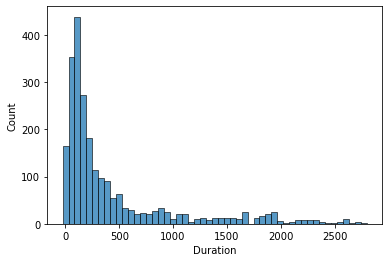

In [23]:
# Lets check if the "Duration" Column has correct data.
print(dataset[['Duration']].describe().T)
sns.histplot(dataset['Duration'])
plt.show()

# There are some very high values for "Duration" which can be dealt with later.
# But "Duration" feature also has negative values. But time can never be negative. Lets inspect further.

In [24]:
#Checking for observations which have negative values.
dataset[dataset['Duration']<0]
# The below records are of drivers who have not churned yet,but have joined OLA in Dec_2020, but the last_monthly_report date is "2020-12-01"
# This is is strange,because the report would get generated on 1st of every month,which is before their joining date.
# We can therefore drop these drivers because of this incorrect data

,Driver_ID,Churn,LastWorkingDate,MMM-YY,Last_Date,Dateofjoining,Duration
6,11,0,NaT,2020-12-01,2020-12-01,2020-12-07,-6
124,148,0,NaT,2020-12-01,2020-12-01,2020-12-11,-10
175,205,0,NaT,2020-12-01,2020-12-01,2020-12-20,-19
228,274,0,NaT,2020-12-01,2020-12-01,2020-12-20,-19
240,288,0,NaT,2020-12-01,2020-12-01,2020-12-18,-17
249,297,0,NaT,2020-12-01,2020-12-01,2020-12-19,-18
257,309,0,NaT,2020-12-01,2020-12-01,2020-12-11,-10
258,310,0,NaT,2020-12-01,2020-12-01,2020-12-11,-10
319,378,0,NaT,2020-12-01,2020-12-01,2020-12-13,-12
333,398,0,NaT,2020-12-01,2020-12-01,2020-12-07,-6


In [25]:
# Getting the list of above Drivers.
drivers_to_drop=list(set(dataset.loc[dataset['Duration']<0,'Driver_ID']))

# Lets have a look at few of the records of these drivers.
df[df['Driver_ID'].isin(drivers_to_drop)][:10]
# The same issue can be seen from below records as well. The joining date is after the date of report generation.

,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating,Churn
21,2020-12-01,11,28.0,1.0,C19,2,42172,2020-12-07,NaT,1,1,0,1,0.0
994,2020-12-01,148,41.0,0.0,C15,0,45288,2020-12-11,NaT,2,2,0,1,0.0
1396,2020-12-01,205,39.0,0.0,C12,0,15826,2020-12-20,NaT,1,1,0,1,0.0
1774,2020-12-01,274,39.0,0.0,C7,1,53224,2020-12-20,NaT,2,2,0,1,0.0
1852,2020-12-01,288,41.0,1.0,C17,0,62901,2020-12-18,NaT,2,2,0,1,0.0
1907,2020-12-01,297,38.0,0.0,C8,2,109473,2020-12-19,NaT,3,3,0,1,0.0
1974,2020-12-01,309,30.0,1.0,C5,1,77597,2020-12-11,NaT,3,3,0,1,0.0
1975,2020-12-01,310,27.0,1.0,C3,2,58439,2020-12-11,NaT,1,1,0,1,0.0
2466,2020-12-01,378,33.0,0.0,C9,2,35057,2020-12-13,NaT,3,3,0,1,0.0
2584,2020-12-01,398,30.0,0.0,C5,2,63280,2020-12-07,NaT,2,2,0,1,0.0


In [26]:
# Lets drop the above drivers from both our datasets.
dataset=dataset[~dataset['Driver_ID'].isin(drivers_to_drop)]
df=df[~df['Driver_ID'].isin(drivers_to_drop)]
dataset.reset_index(drop=True,inplace=True)
df.reset_index(drop=True,inplace=True)

In [27]:
# Dropping the columns - 'LastWorkingDate', 'MMM-YY', 'Last_Date' and'Dateofjoining'
dataset.drop(columns=['LastWorkingDate','MMM-YY','Last_Date','Dateofjoining'],inplace=True)

In [28]:
# A look at our updated dataset.
dataset.head(3)

,Driver_ID,Churn,Duration
0,1,1,77
1,2,0,25
2,4,1,142


### Inspecting and Aggregating "City" for each Driver in the new Dataset 

In [29]:
#Lets do a quick check if there there are multiple cities assigned to each driver
df.groupby(by='Driver_ID').nunique()['City'].value_counts()

# We observe that all drivers have only 1 city mapped against them. Lets create a new feature in our aggregated
# dataset and store the city for each driver

1    2299
Name: City, dtype: int64

In [30]:
#Getting the city for each driver
cities=df.loc[~df[['Driver_ID','City']].duplicated(),['Driver_ID','City']]
cities.head()

,Driver_ID,City
0,1,C23
3,2,C7
5,4,C13
10,5,C9
13,6,C11


In [31]:
    dataset = pd.merge(left=dataset,right=cities,on='Driver_ID')
    dataset.head()
    #Sucessfully created a new feature which stores the city for each driver.

,Driver_ID,Churn,Duration,City
0,1,1,77,C23
1,2,0,25,C7
2,4,1,142,C13
3,5,1,57,C9
4,6,0,123,C11


### Inspecting and Aggregating "Education_Level" for each Driver in the new Dataset 

In [32]:
#Lets do a quick check if there there are multiple cities assigned to each driver
df.groupby(by='Driver_ID').nunique()['Education_Level'].value_counts()

#We observe that all drivers have only 1 Education_Level against them. Lets create a new feature in our aggregated
# dataset and store the Education_Level for each driver

1    2299
Name: Education_Level, dtype: int64

In [33]:
# Lets look at the different values of Education_Level
df['Education_Level'].unique()

array([2, 0, 1], dtype=int64)

In [34]:
#Getting the Education_Level for each driver
education_level=df.loc[~df[['Driver_ID','Education_Level']].duplicated(),['Driver_ID','Education_Level']]
education_level.head()

,Driver_ID,Education_Level
0,1,2
3,2,2
5,4,2
10,5,0
13,6,1


In [35]:
dataset = pd.merge(left=dataset,right=education_level,on='Driver_ID')
dataset.head()
#Sucessfully created a new feature which stores the city for each driver.

,Driver_ID,Churn,Duration,City,Education_Level
0,1,1,77,C23,2
1,2,0,25,C7,2
2,4,1,142,C13,2
3,5,1,57,C9,0
4,6,0,123,C11,1


### Inspecting and Aggregating "Income" for each Driver in the new Dataset 

In [36]:
# Lets have a look at few observation to understand how average income for each driver is stored in the dataset.
df.head(15)

#It seems that the average income is repeated for every observation of each driver.

,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating,Churn
0,2019-01-01,1,28.0,0.0,C23,2,57387,2018-12-24,NaT,1,1,2381060,2,0.0
1,2019-02-01,1,28.0,0.0,C23,2,57387,2018-12-24,NaT,1,1,-665480,2,0.0
2,2019-03-01,1,28.0,0.0,C23,2,57387,2018-12-24,2019-03-11,1,1,0,2,1.0
3,2020-11-01,2,31.0,0.0,C7,2,67016,2020-11-06,NaT,2,2,0,1,0.0
4,2020-12-01,2,31.0,0.0,C7,2,67016,2020-11-06,NaT,2,2,0,1,0.0
5,2019-12-01,4,43.0,0.0,C13,2,65603,2019-12-07,NaT,2,2,0,1,0.0
6,2020-01-01,4,43.0,0.0,C13,2,65603,2019-12-07,NaT,2,2,0,1,0.0
7,2020-02-01,4,43.0,0.0,C13,2,65603,2019-12-07,NaT,2,2,0,1,0.0
8,2020-03-01,4,43.0,0.0,C13,2,65603,2019-12-07,NaT,2,2,350000,1,0.0
9,2020-04-01,4,43.0,0.0,C13,2,65603,2019-12-07,2020-04-27,2,2,0,1,1.0


In [37]:
#Lets do a quick check if there there are multiple incomes assigned to each driver
df.groupby(by='Driver_ID').nunique()['Income'].value_counts()

#We observe that most drivers have only 1 Income against them. 
#However there are few drivers who have 2 different average incomes. Lets inspect.

1    2255
2      44
Name: Income, dtype: int64

In [38]:
income_count=(df.groupby(by='Driver_ID').nunique()['Income'])
income_count[income_count==2].index

# These drivers have 2 average incomes in the dataset. Lets look at the observations for driver_id 26.

Int64Index([  26,   54,   60,   98,  275,  307,  320,  368,  434,  537,  568,
             580,  582,  638,  716,  789,  888, 1031, 1050, 1161, 1165, 1206,
            1249, 1274, 1316, 1327, 1770, 1783, 1817, 1840, 1852, 1877, 1918,
            2008, 2070, 2087, 2198, 2272, 2390, 2407, 2543, 2567, 2625, 2690],
           dtype='int64', name='Driver_ID')

In [39]:
df[df['Driver_ID']==26]

# We can confirm from the below observations that certain drivers have 2 different incomes.

,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating,Churn
137,2019-01-01,26,41.0,0.0,C14,2,121529,2018-05-07,NaT,1,3,243110,4,0.0
138,2019-02-01,26,41.0,0.0,C14,2,121529,2018-05-07,NaT,1,3,646330,4,0.0
139,2019-03-01,26,41.0,0.0,C14,2,121529,2018-05-07,NaT,1,3,17651940,4,0.0
140,2019-04-01,26,41.0,0.0,C14,2,121529,2018-05-07,NaT,1,3,242510,4,0.0
141,2019-05-01,26,41.0,0.0,C14,2,121529,2018-05-07,NaT,1,3,1098080,4,0.0
142,2019-06-01,26,41.0,0.0,C14,2,121529,2018-05-07,NaT,1,3,1212720,4,0.0
143,2019-07-01,26,41.0,0.0,C14,2,121529,2018-05-07,NaT,1,3,2695910,4,0.0
144,2019-08-01,26,41.0,0.0,C14,2,121529,2018-05-07,NaT,1,3,494710,4,0.0
145,2019-09-01,26,42.0,0.0,C14,2,121529,2018-05-07,NaT,1,3,986540,4,0.0
146,2019-10-01,26,42.0,0.0,C14,2,121529,2018-05-07,NaT,1,3,9950710,4,0.0


In [40]:
#Lets find out the average income of each driver and store it in the aggragated dataset.
income_avg=df.groupby(by='Driver_ID').mean()['Income'].reset_index()
income_avg[:5]

,Driver_ID,Income
0,1,57387.0
1,2,67016.0
2,4,65603.0
3,5,46368.0
4,6,78728.0


In [41]:
dataset=pd.merge(left=dataset,right=income_avg,on='Driver_ID')
dataset.head()
#Sucessfully created a new feature which stores the average_income for each driver.

,Driver_ID,Churn,Duration,City,Education_Level,Income
0,1,1,77,C23,2,57387.0
1,2,0,25,C7,2,67016.0
2,4,1,142,C13,2,65603.0
3,5,1,57,C9,0,46368.0
4,6,0,123,C11,1,78728.0


In [42]:
# Lets do another Feature Engineering step for Income
# If the income has increased for a particular driver, then we can flag him as 1, or else 0.
# To achieve this, we can compare the first month income and last month income for every driver.

# Getting the list of driver_ids
all_driver_ids=dataset['Driver_ID']

#Getting the indexes for every driver, and storing the key-value pair in a dict
dict1={}
for id in all_driver_ids:
    dict1[id]=list(df[df['Driver_ID']==id].index)

In [43]:
# Creating a Flag Column
dataset['Income_Flag']=-1

# Now lets compare the first and last month income for every driver and create the flag feature in our dataset.
for driver_id in all_driver_ids:
    first_index=min(dict1[driver_id])
    last_index=max(dict1[driver_id])
    first_income=df.iloc[first_index]['Income']
    last_income=df.iloc[last_index]['Income']
    if last_income>first_income:
        dataset.loc[dataset['Driver_ID']==driver_id,'Income_Flag']=1
    else:
        dataset.loc[dataset['Driver_ID']==driver_id,'Income_Flag']=0

In [44]:
# Lets have a look at the new feature that we created.
dataset.head()

,Driver_ID,Churn,Duration,City,Education_Level,Income,Income_Flag
0,1,1,77,C23,2,57387.0,0
1,2,0,25,C7,2,67016.0,0
2,4,1,142,C13,2,65603.0,0
3,5,1,57,C9,0,46368.0,0
4,6,0,123,C11,1,78728.0,0


### Inspecting and Aggregating "Age" for each Driver in the new Dataset 

In [45]:
# From the inspection done earlier, we know "Age" feature has missing values.
df['Age'].isna().sum()

61

In [46]:
# Lets inspect the dataset for missing values in age feature
df[df['Age'].isna()]

,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating,Churn
71,2020-02-01,20,NaN,1.0,C19,0,40342,2019-10-25,NaT,3,3,0,1,0.0
96,2019-10-01,22,NaN,0.0,C10,2,31224,2018-05-25,NaT,1,1,200000,3,0.0
109,2019-07-01,24,NaN,0.0,C24,2,76308,2018-05-25,NaT,1,2,203240,3,0.0
211,2019-11-01,40,NaN,0.0,C15,0,59182,2019-11-08,NaT,2,2,0,1,0.0
260,2019-05-01,49,NaN,0.0,C20,0,53039,2018-05-25,NaT,1,2,124190,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18180,2020-05-01,2690,NaN,0.0,C11,2,77662,2018-07-17,NaT,1,2,692600,4,0.0
18507,2020-08-01,2730,NaN,1.0,C16,2,69924,2019-07-08,NaT,2,2,161860,2,0.0
18565,2019-03-01,2738,NaN,0.0,C17,0,23068,2018-09-08,NaT,1,1,639780,3,0.0
18628,2019-01-01,2751,NaN,0.0,C17,2,53115,2015-11-05,NaT,1,1,506550,3,0.0


In [47]:
# Lets get the list of driver_ids for whom there are missing values in Age.
missing_age_driver_ids=list(set(df.loc[df['Age'].isna(),'Driver_ID']))
len(missing_age_driver_ids)
#There are total 57 such drivers.

57

In [48]:
# As this dataset has more than 1 observation for every driver,lets check for valid values of "Age" for these drivers
# Since the records could be more than 12 months long, lets check for the maximum age of each driver, since age may change.
missing_age_drivers_found=df[df['Driver_ID'].isin(missing_age_driver_ids)].groupby('Driver_ID').max()['Age']
missing_age_drivers_found

#We found valid age for each of these drivers. Lets use these values in our dataset.

Driver_ID
20      26.0
22      41.0
24      31.0
40      32.0
49      22.0
63      28.0
69      32.0
103     26.0
120     27.0
167     26.0
179     26.0
183     26.0
204     31.0
215     26.0
305     24.0
313     31.0
325     26.0
369     32.0
422     27.0
458     31.0
541     27.0
560     42.0
607     27.0
617     22.0
718     27.0
778     31.0
901     32.0
954     31.0
1050    32.0
1072    28.0
1247    32.0
1378    28.0
1421    27.0
1430    31.0
1462    27.0
1588    42.0
1611    31.0
1669    22.0
1720    33.0
1852    55.0
1909    31.0
1932    28.0
1936    26.0
2073    21.0
2168    40.0
2273    32.0
2348    24.0
2351    31.0
2460    26.0
2507    26.0
2569    27.0
2618    28.0
2690    26.0
2730    32.0
2738    24.0
2751    32.0
2774    41.0
Name: Age, dtype: float64

In [49]:
mapping=dict(zip(list(missing_age_drivers_found.index),list(missing_age_drivers_found)))
mapping
#Now lets fill the missing age values.

for d_id in missing_age_driver_ids:
    df.loc[df['Driver_ID']==d_id,'Age']=mapping[d_id]

In [50]:
#Checking if missing values have been removed
df['Age'].isna().sum()

0

In [51]:
# Now lets store the max age of all drivers in the aggregate dataset
max_ages_of_drivers=df.groupby(by='Driver_ID').max()['Age']

dataset=pd.merge(left=dataset,right=max_ages_of_drivers,on='Driver_ID')
dataset.head()
#Sucessfully created a new feature which stores the max Age for each driver.

,Driver_ID,Churn,Duration,City,Education_Level,Income,Income_Flag,Age
0,1,1,77,C23,2,57387.0,0,28.0
1,2,0,25,C7,2,67016.0,0,31.0
2,4,1,142,C13,2,65603.0,0,43.0
3,5,1,57,C9,0,46368.0,0,29.0
4,6,0,123,C11,1,78728.0,0,31.0


### Inspecting and Aggregating "Gender" for each Driver in the new Dataset 

In [52]:
# There were few missing values in "Gender" Feature found in our preliminary analysis
df['Gender'].isna().sum()

52

In [53]:
# Lets check few the observation where there are missing values in the "Gender" feature
df[df['Gender'].isna()][:20]

,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating,Churn
239,2019-02-01,43,27.0,NaN,C15,0,12906,2018-07-13,2019-02-20,1,1,0,1,1.0
257,2019-02-01,49,22.0,NaN,C20,0,53039,2018-05-25,NaT,1,2,0,1,0.0
263,2019-08-01,49,22.0,NaN,C20,0,53039,2018-05-25,NaT,1,2,300300,2,0.0
463,2019-08-01,68,31.0,NaN,C29,0,79288,2015-10-18,NaT,1,3,544930,3,0.0
817,2019-02-01,116,21.0,NaN,C11,0,16477,2018-12-04,NaT,1,1,129590,1,0.0
856,2019-11-01,119,31.0,NaN,C29,1,71000,2019-11-16,NaT,3,3,0,1,0.0
1509,2020-12-01,225,32.0,NaN,C14,0,44792,2020-07-13,NaT,3,3,337020,3,0.0
1885,2019-08-01,296,31.0,NaN,C20,1,65094,2018-06-10,NaT,1,2,145670,2,0.0
2267,2019-02-01,354,31.0,NaN,C11,0,60555,2018-11-30,NaT,1,1,0,1,0.0
2349,2020-03-01,365,24.0,NaN,C22,0,44740,2020-02-01,NaT,2,2,0,1,0.0


In [54]:
# Lets get the driver_id for whom there are missing values in "Gender" column
gender_missing_driver_ids=list(set(df.loc[df['Gender'].isna(),'Driver_ID']))
len(gender_missing_driver_ids)
# There are total 51 driver_ids for whom there are missing values in Gender

51

In [55]:
# Lets check if we have values present for "Gender" in other observations for the same driver_ids.
temp=df[df['Driver_ID'].isin(gender_missing_driver_ids)]
temp=temp.loc[~temp['Gender'].isna(),['Driver_ID','Gender']]
temp=temp[~temp.duplicated()]
temp.shape
# There are values present for all the 51 driver_ids

(51, 2)

In [56]:
mapping=dict(zip(temp['Driver_ID'],temp['Gender']))

# Lets replace the missing values in the dataset.
for d_id in gender_missing_driver_ids:
    df.loc[df['Driver_ID']==d_id,'Gender']=mapping[d_id]

In [57]:
#Checking if missing values have been removed
df['Gender'].isna().sum()

0

In [58]:
# Now lets store the Gender of all drivers in the aggregate dataset
gender_drivers=df.loc[(~df[['Driver_ID','Gender']].duplicated()),['Driver_ID','Gender']]

dataset=pd.merge(left=dataset,right=gender_drivers,on='Driver_ID')
dataset.head()
#Sucessfully created a new feature which stores the Gender for each driver.

,Driver_ID,Churn,Duration,City,Education_Level,Income,Income_Flag,Age,Gender
0,1,1,77,C23,2,57387.0,0,28.0,0.0
1,2,0,25,C7,2,67016.0,0,31.0,0.0
2,4,1,142,C13,2,65603.0,0,43.0,0.0
3,5,1,57,C9,0,46368.0,0,29.0,0.0
4,6,0,123,C11,1,78728.0,0,31.0,1.0


#### Note :
It was asked in the question to use KNN_Imputer to impute missing values. However during my exploration process, I found out that there are original values present in the dataset that can be directly used instead of using KNN, which would be an approximation missing value imputation technique.

### Inspecting and Aggregating "Joining_Designation" for each Driver in the new Dataset 

In [59]:
# Lets check if there were multiple Joining_Designation for any of the drivers
df.groupby(by='Driver_ID').nunique()['Joining Designation'].value_counts()

# Observation - All the drivers have only 1 joining designation.

1    2299
Name: Joining Designation, dtype: int64

In [60]:
# We can store the Joining_Designation for each of the drivers in the aggregated dataset.
joining_designation=df.loc[~df[['Driver_ID','Joining Designation']].duplicated(),['Driver_ID','Joining Designation']]

dataset=pd.merge(left=dataset,right=joining_designation,on='Driver_ID')
dataset.head()
#Sucessfully created a new feature which stores the Joining_Designation for each driver.

,Driver_ID,Churn,Duration,City,Education_Level,Income,Income_Flag,Age,Gender,Joining Designation
0,1,1,77,C23,2,57387.0,0,28.0,0.0,1
1,2,0,25,C7,2,67016.0,0,31.0,0.0,2
2,4,1,142,C13,2,65603.0,0,43.0,0.0,2
3,5,1,57,C9,0,46368.0,0,29.0,0.0,1
4,6,0,123,C11,1,78728.0,0,31.0,1.0,3


### Inspecting and Aggregating "Grade" for each Driver in the new Dataset 

In [61]:
# Lets check if there are multiple Grades for any of the drivers
df.groupby(by='Driver_ID').nunique()['Grade'].value_counts()

# Observation - Maximum drivers have 2 Grades,& few drivers have 1 Grade.Lets check few records for drivers having 2 Grades.

1    2255
2      44
Name: Grade, dtype: int64

In [62]:
temp=df.groupby(by='Driver_ID').nunique()['Grade']
multiple_grade_driver_ids=temp[temp==2].index
len(multiple_grade_driver_ids)

#There are 44 drivers who have 2 Grades. Lets have a look the observations for one such driver.

44

In [63]:
df[df['Driver_ID']==multiple_grade_driver_ids[0]]
# Perhaps with increase in time and performace, the Grade increases for drivers.

,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating,Churn
137,2019-01-01,26,41.0,0.0,C14,2,121529,2018-05-07,NaT,1,3,243110,4,0.0
138,2019-02-01,26,41.0,0.0,C14,2,121529,2018-05-07,NaT,1,3,646330,4,0.0
139,2019-03-01,26,41.0,0.0,C14,2,121529,2018-05-07,NaT,1,3,17651940,4,0.0
140,2019-04-01,26,41.0,0.0,C14,2,121529,2018-05-07,NaT,1,3,242510,4,0.0
141,2019-05-01,26,41.0,0.0,C14,2,121529,2018-05-07,NaT,1,3,1098080,4,0.0
142,2019-06-01,26,41.0,0.0,C14,2,121529,2018-05-07,NaT,1,3,1212720,4,0.0
143,2019-07-01,26,41.0,0.0,C14,2,121529,2018-05-07,NaT,1,3,2695910,4,0.0
144,2019-08-01,26,41.0,0.0,C14,2,121529,2018-05-07,NaT,1,3,494710,4,0.0
145,2019-09-01,26,42.0,0.0,C14,2,121529,2018-05-07,NaT,1,3,986540,4,0.0
146,2019-10-01,26,42.0,0.0,C14,2,121529,2018-05-07,NaT,1,3,9950710,4,0.0


In [64]:
# Now lets store the Maximum Grade of all drivers in the aggregate dataset
grade_of_driver_ids=df.groupby(by='Driver_ID').max()['Grade']

dataset=pd.merge(left=dataset,right=grade_of_driver_ids,on='Driver_ID')
dataset.head()
#Sucessfully created a new feature which stores the Max Grade for each driver.

,Driver_ID,Churn,Duration,City,Education_Level,Income,Income_Flag,Age,Gender,Joining Designation,Grade
0,1,1,77,C23,2,57387.0,0,28.0,0.0,1,1
1,2,0,25,C7,2,67016.0,0,31.0,0.0,2,2
2,4,1,142,C13,2,65603.0,0,43.0,0.0,2,2
3,5,1,57,C9,0,46368.0,0,29.0,0.0,1,1
4,6,0,123,C11,1,78728.0,0,31.0,1.0,3,3


### Inspecting and Aggregating "Total Business Value" for each Driver in the new Dataset 

In [65]:
# For "Total Business Value", we can take the summation of the all the observations for this feature for each driver.
total_business_of_each_driver=df.groupby(by='Driver_ID').sum()['Total Business Value']


dataset=pd.merge(left=dataset,right=total_business_of_each_driver,on='Driver_ID')
dataset.head()
#Sucessfully created a new feature which stores the sum of total_business_value for each driver in the aggregated dataset.

,Driver_ID,Churn,Duration,City,Education_Level,Income,Income_Flag,Age,Gender,Joining Designation,Grade,Total Business Value
0,1,1,77,C23,2,57387.0,0,28.0,0.0,1,1,1715580
1,2,0,25,C7,2,67016.0,0,31.0,0.0,2,2,0
2,4,1,142,C13,2,65603.0,0,43.0,0.0,2,2,350000
3,5,1,57,C9,0,46368.0,0,29.0,0.0,1,1,120360
4,6,0,123,C11,1,78728.0,0,31.0,1.0,3,3,1265000


### Inspecting and Aggregating "Quarterly Rating" for each Driver in the new Dataset 

In [66]:
# Lets check if there were multiple Quarterly Ratings for any of the drivers
df.groupby(by='Driver_ID').nunique()['Quarterly Rating'].value_counts()

#Observation-Drivers have got different ratings as per their quarter performance.Most have got 1 kind of rating consitently.

1    1203
2     654
3     352
4      90
Name: Quarterly Rating, dtype: int64

In [67]:
# Now lets store the Average Quarterly Ratings of all drivers in the aggregate dataset
ratings_drivers=df.groupby(by='Driver_ID').mean()['Quarterly Rating']

dataset=pd.merge(left=dataset,right=ratings_drivers,on='Driver_ID')
dataset.head()
#Sucessfully created a new feature which stores the Average Quarterly Ratings for each driver.

,Driver_ID,Churn,Duration,City,Education_Level,Income,Income_Flag,Age,Gender,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,1,1,77,C23,2,57387.0,0,28.0,0.0,1,1,1715580,2.0
1,2,0,25,C7,2,67016.0,0,31.0,0.0,2,2,0,1.0
2,4,1,142,C13,2,65603.0,0,43.0,0.0,2,2,350000,1.0
3,5,1,57,C9,0,46368.0,0,29.0,0.0,1,1,120360,1.0
4,6,0,123,C11,1,78728.0,0,31.0,1.0,3,3,1265000,1.6


In [68]:
# Lets do another Feature Engineering step for Quarterly_Rating
# If the Quarterly_Rating has increased for a particular driver, then we can flag him as 1, or else 0.
# To achieve this, we can compare the first month Quarterly_Rating and last month Quarterly_Rating for every driver.

# Getting the list of driver_ids
all_driver_ids=dataset['Driver_ID']

#Getting the indexes for every driver, and storing the key-value pair in a dict
dict1={}
for id in all_driver_ids:
    dict1[id]=list(df[df['Driver_ID']==id].index)

In [69]:
# Creating a Flag Column
dataset['Quarterly_Rating_Flag']=-1

# Now lets compare the first and last month Quarterly_Rating for every driver and create the flag feature in our dataset.
for driver_id in all_driver_ids:
    first_index=min(dict1[driver_id])
    last_index=max(dict1[driver_id])
    first_income=df.iloc[first_index]['Quarterly Rating']
    last_income=df.iloc[last_index]['Quarterly Rating']
    if last_income>first_income:
        dataset.loc[dataset['Driver_ID']==driver_id,'Quarterly_Rating_Flag']=1
    else:
        dataset.loc[dataset['Driver_ID']==driver_id,'Quarterly_Rating_Flag']=0

In [70]:
# Lets have a look at the new feature that we created.
dataset.head()

,Driver_ID,Churn,Duration,City,Education_Level,Income,Income_Flag,Age,Gender,Joining Designation,Grade,Total Business Value,Quarterly Rating,Quarterly_Rating_Flag
0,1,1,77,C23,2,57387.0,0,28.0,0.0,1,1,1715580,2.0,0
1,2,0,25,C7,2,67016.0,0,31.0,0.0,2,2,0,1.0,0
2,4,1,142,C13,2,65603.0,0,43.0,0.0,2,2,350000,1.0,0
3,5,1,57,C9,0,46368.0,0,29.0,0.0,1,1,120360,1.0,0
4,6,0,123,C11,1,78728.0,0,31.0,1.0,3,3,1265000,1.6,1


## Final Dataset 

In [71]:
# We have our final aggregated dataset, which can be used for analysis and model building.
dataset.head()

# Taking a look at out Final_Dataset.
dataset.head()

,Driver_ID,Churn,Duration,City,Education_Level,Income,Income_Flag,Age,Gender,Joining Designation,Grade,Total Business Value,Quarterly Rating,Quarterly_Rating_Flag
0,1,1,77,C23,2,57387.0,0,28.0,0.0,1,1,1715580,2.0,0
1,2,0,25,C7,2,67016.0,0,31.0,0.0,2,2,0,1.0,0
2,4,1,142,C13,2,65603.0,0,43.0,0.0,2,2,350000,1.0,0
3,5,1,57,C9,0,46368.0,0,29.0,0.0,1,1,120360,1.0,0
4,6,0,123,C11,1,78728.0,0,31.0,1.0,3,3,1265000,1.6,1


In [72]:
#Checking the shape of the dataset
dataset.shape

(2299, 14)

In [73]:
# Final Check for NULL values
dataset.isna().sum()
#There are no null values.

Driver_ID                0
Churn                    0
Duration                 0
City                     0
Education_Level          0
Income                   0
Income_Flag              0
Age                      0
Gender                   0
Joining Designation      0
Grade                    0
Total Business Value     0
Quarterly Rating         0
Quarterly_Rating_Flag    0
dtype: int64

In [74]:
# Checking the Data Types of the columns
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2299 entries, 0 to 2298
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Driver_ID              2299 non-null   int64  
 1   Churn                  2299 non-null   int64  
 2   Duration               2299 non-null   int64  
 3   City                   2299 non-null   object 
 4   Education_Level        2299 non-null   int64  
 5   Income                 2299 non-null   float64
 6   Income_Flag            2299 non-null   int64  
 7   Age                    2299 non-null   float64
 8   Gender                 2299 non-null   float64
 9   Joining Designation    2299 non-null   int64  
 10  Grade                  2299 non-null   int64  
 11  Total Business Value   2299 non-null   int64  
 12  Quarterly Rating       2299 non-null   float64
 13  Quarterly_Rating_Flag  2299 non-null   int64  
dtypes: float64(4), int64(9), object(1)
memory usage: 269.4+ 

In [75]:
#Checking for duplicate values.
dataset[dataset.duplicated()]
# There are not duplicate values.

,Driver_ID,Churn,Duration,City,Education_Level,Income,Income_Flag,Age,Gender,Joining Designation,Grade,Total Business Value,Quarterly Rating,Quarterly_Rating_Flag


### Lets determine the categorical and continuous columns in our dataset.

In [76]:
data_types=[]
categories=[]
for column in dataset.columns:
    categories.append(dataset[column].nunique())
    data_types.append(dataset[column].dtype)

pd.DataFrame(data=[categories,data_types],index=['Categories','Data_Type'],columns=dataset.columns).T

,Categories,Data_Type
Driver_ID,2299,int64
Churn,2,int64
Duration,879,int64
City,29,object
Education_Level,3,int64
Income,2260,float64
Income_Flag,2,int64
Age,36,float64
Gender,2,float64
Joining Designation,5,int64


In [77]:
continuous_columns=['Duration','Income','Age','Total Business Value','Quarterly Rating']
categorical_columns=['City','Education_Level','Income_Flag','Gender','Joining Designation','Grade','Quarterly_Rating_Flag']

In [78]:
# Converting the data type of categorical columns to category
for column in categorical_columns:
    dataset[column]=dataset[column].astype('category')

### Splitting The Data

In [79]:
# Splitting the dataset into train and test datasets
dataset_train,dataset_test=train_test_split(dataset,test_size=0.2,random_state=42,stratify=dataset['Churn'])
print("Train",dataset_train.shape)
print("Test",dataset_test.shape)

Train (1839, 14)
Test (460, 14)


#### Lets keep the Test_Data aside for now.

### Descriptive Statistics

In [80]:
# Continuous Variables
dataset_train[continuous_columns].describe()

,Duration,Income,Age,Total Business Value,Quarterly Rating
count,1839.000000,1839.000000,1839.000000,1.839000e+03,1839.000000
mean,435.377379,59156.150565,33.764546,4.714062e+06,1.580203
std,570.022273,28358.625209,6.007660,9.237594e+06,0.725855
min,0.000000,10747.000000,21.000000,-1.385530e+06,1.000000
25%,97.000000,39111.500000,29.000000,0.000000e+00,1.000000
50%,185.000000,55108.000000,33.000000,8.643500e+05,1.200000
75%,479.000000,75380.500000,37.000000,4.272055e+06,2.000000
max,2801.000000,188418.000000,58.000000,9.533106e+07,4.000000


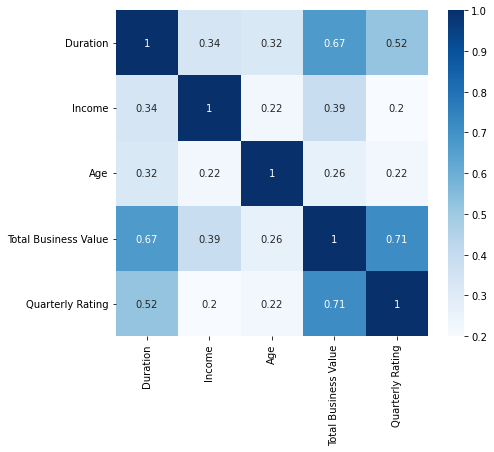

In [81]:
plt.figure(figsize=(7,6))
sns.heatmap(dataset_train[continuous_columns].corr(),annot=True,cmap='Blues')
plt.show()

#### There is strong correlation between :
- "Duration" and "Total_Business_Value"
- "Quarterly_Rating" and "Total_Business_Value"
- "Duration" and "Quarterly_Rating"

In [82]:
# Categorical Variables
dataset_train[categorical_columns].describe()

,City,Education_Level,Income_Flag,Gender,Joining Designation,Grade,Quarterly_Rating_Flag
count,1839,1839,1839,1839.0,1839,1839,1839
unique,29,3,2,2.0,5,5,2
top,C20,1,0,0.0,1,2,0
freq,115,622,1807,1074.0,798,661,1562


## Analysis

### Churn

1    70.0
0    30.0
Name: Churn, dtype: float64


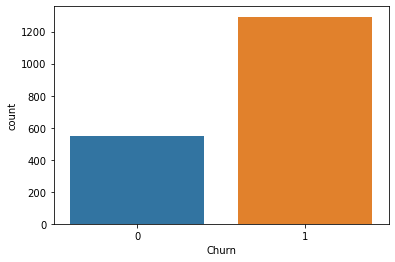

In [83]:
#Target Column - Churn
print(np.round(100*dataset_train['Churn'].value_counts(normalize=True)))
sns.countplot(data=dataset_train,x='Churn')
plt.show()
# We have imbalanced data. Need to balance the data before building the model.

### Duration

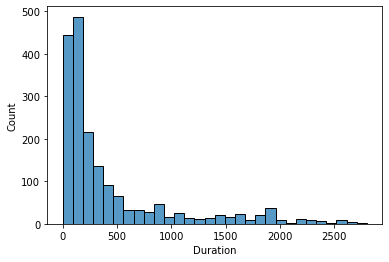

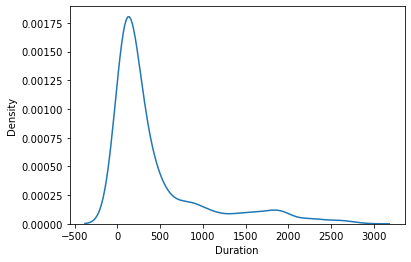

In [84]:
# Lets look at the distribution of "Duration"
sns.histplot(data=dataset_train,x='Duration',bins=30)
plt.show()

sns.kdeplot(data=dataset_train,x='Duration')
plt.show()

# The distribution is highly right skewed.
# We can use Transformation to try to make it Normally Distributed.

In [85]:
#Lets check the range of "Duration" feature.
dataset_train['Duration'].describe()

# The minimum value is 0, we cannot use Log_Transformation here, since log(0) is -inf.
# Box-Cox tranformation also cannot be used, since Box-Cox transformation can only be used for positive values.
# Lets try using Yeo-Johnson Transformation

count    1839.000000
mean      435.377379
std       570.022273
min         0.000000
25%        97.000000
50%       185.000000
75%       479.000000
max      2801.000000
Name: Duration, dtype: float64

In [86]:
yeo_johnson_transfomer=PowerTransformer(method='yeo-johnson')
Duration_transformed=yeo_johnson_transfomer.fit_transform(dataset_train[['Duration']])

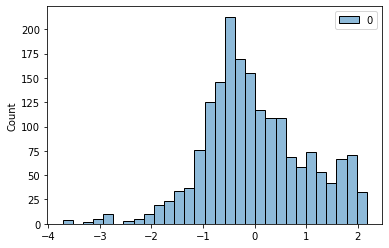

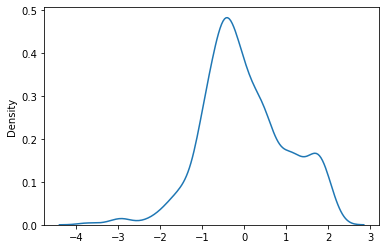

In [87]:
# Lets look at the distribution of "Duration"
sns.histplot(Duration_transformed,bins=30)
plt.show()

sns.kdeplot(Duration_transformed.reshape(-1))
plt.show()

# The distribution is not exactly normal, but it is better than than the original distribution.
# We can use Yeo-Johnson transformation on "Duration" feature.

In [88]:
# Transforming the "Duration" column
dataset_train['Duration']=Duration_transformed.reshape(-1)
dataset_test['Duration']=yeo_johnson_transfomer.transform(dataset_test[['Duration']]).reshape(-1)

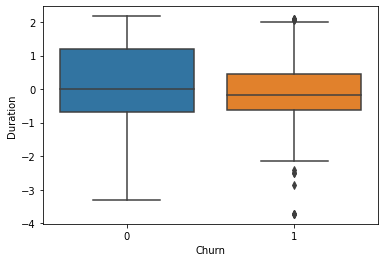

In [89]:
# Relationship of Duration with Churn 
sns.boxplot(data=dataset_train,x='Churn',y='Duration')
plt.show()
# For people who Churn, the median Duration is lower.

### City

In [90]:
# Lets look at the unique number of categories for "City" Feature
print(dataset_train['City'].nunique(),"Categories") # There are 29 cities.
print(dataset_train['City'].unique())

29 Categories
['C4', 'C29', 'C6', 'C9', 'C7', ..., 'C5', 'C12', 'C13', 'C11', 'C18']
Length: 29
Categories (29, object): ['C1', 'C10', 'C11', 'C12', ..., 'C6', 'C7', 'C8', 'C9']


In [91]:
# Lets look at the frequecies of the difference categories.
round(dataset_train['City'].value_counts(normalize=True)*100,2)

C20    6.25
C15    4.19
C26    4.19
C27    4.02
C29    3.92
C16    3.70
C1     3.64
C14    3.64
C10    3.59
C28    3.48
C3     3.43
C8     3.37
C4     3.37
C22    3.26
C21    3.26
C2     3.26
C18    3.26
C5     3.21
C9     3.21
C25    3.15
C12    3.10
C6     3.05
C23    2.99
C24    2.99
C7     2.99
C11    2.94
C19    2.88
C17    2.88
C13    2.77
Name: City, dtype: float64

In [92]:
# We can One-Hot-Encode this categorical column later.

### Education_Level

1    33.82
2    33.55
0    32.63
Name: Education_Level, dtype: float64


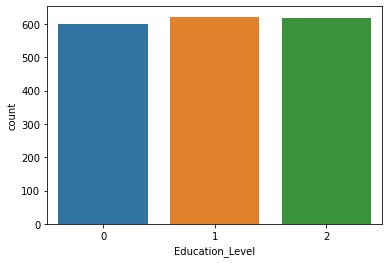

In [93]:
# Lets check the frequency counts of the different categories of "Education_Level" feature.
print(round(100*dataset_train['Education_Level'].value_counts(normalize=True),2))
sns.countplot(dataset_train['Education_Level'])
plt.show()

# The percentages of the different categories appearing are almost same.

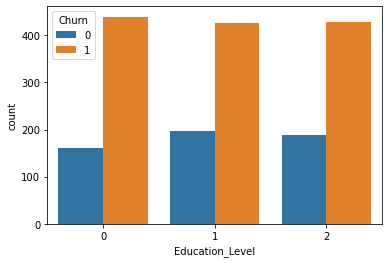

In [94]:
# Relationship of Churn with Education_Level
sns.countplot(data=dataset_train,hue='Churn',x='Education_Level')
plt.show()

# The ratio of churn to non-churn is little different for Education_Level-0

### Income

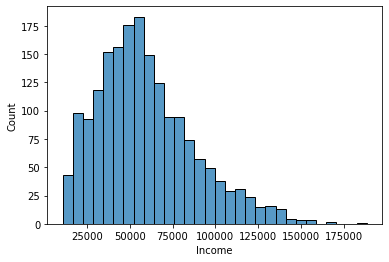

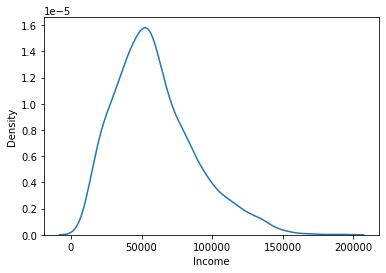

In [95]:
# Lets look at the distribution of "Income"
sns.histplot(data=dataset_train,x='Income',bins=30)
plt.show()

sns.kdeplot(data=dataset_train,x='Income')
plt.show()

# The distribution is right skewed.
# We can use Transformation to try to make it Normally Distributed.

In [96]:
#Lets check the range of "Income" feature.
dataset_train['Income'].describe()

# We can use Log Transformation to try to make it Normally Distributed.

count      1839.000000
mean      59156.150565
std       28358.625209
min       10747.000000
25%       39111.500000
50%       55108.000000
75%       75380.500000
max      188418.000000
Name: Income, dtype: float64

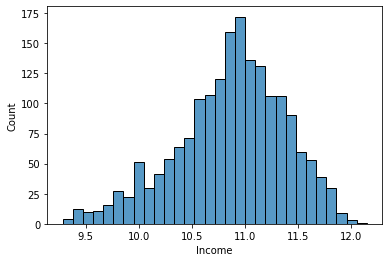

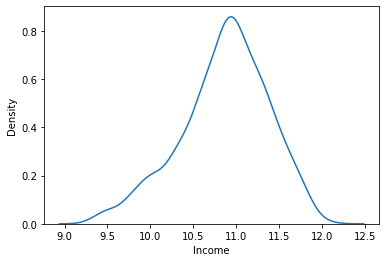

In [97]:
sns.histplot(np.log(dataset_train['Income']),bins=30)
plt.show()

sns.kdeplot(np.log(dataset_train['Income']))
plt.show()

# After doing Log Transformation, we get a distribution which is almost Normally Distributed.
# We can use Log transformation on "Income" feature.

In [98]:
# Transforming the "Income" column
dataset_train['Income']=np.log(dataset_train['Income'])
dataset_test['Income']=np.log(dataset_test['Income'])

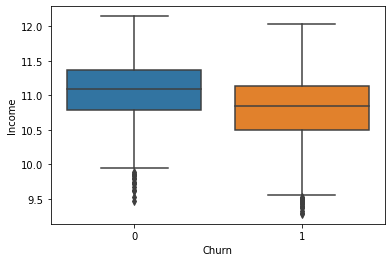

In [99]:
# Relationship of Income with Churn 
sns.boxplot(data=dataset_train,x='Churn',y='Income')
plt.show()
# For people who Churn, the median Income is lower.

### Income_Flag

0    98.26
1     1.74
Name: Income_Flag, dtype: float64


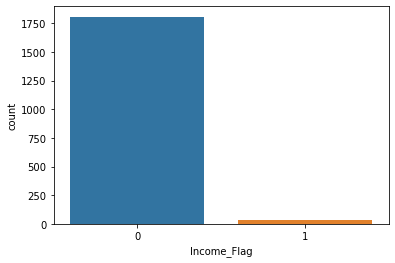

In [100]:
# Lets look at the frequecies of the difference categories of "Income_Flag".
print(round(dataset_train['Income_Flag'].value_counts(normalize=True)*100,2))
sns.countplot(dataset_train['Income_Flag'])
plt.show()

# Income Flag-1 signifies that the income of a particular driver has increased over time.
# For very few people, the income has increased.

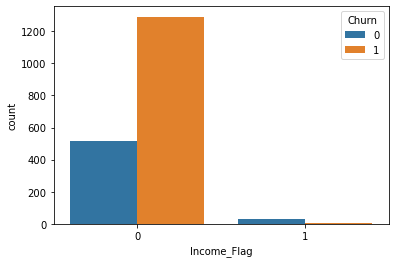

Income_Flag,0,1
Churn,,
0,0.28611,0.90625
1,0.71389,0.09375


In [101]:
# Relationship of Churn with Income_Flag
sns.countplot(data=dataset_train,hue='Churn',x='Income_Flag')
plt.show()

# The ratio of churn to non-churn is different for different Income_Flag.

pd.crosstab(dataset_train['Churn'],dataset_train['Income_Flag'],normalize='columns')

### Age

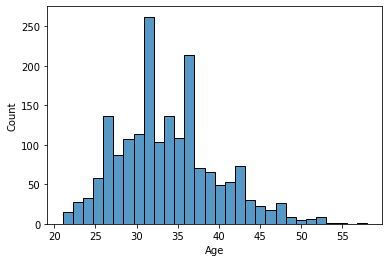

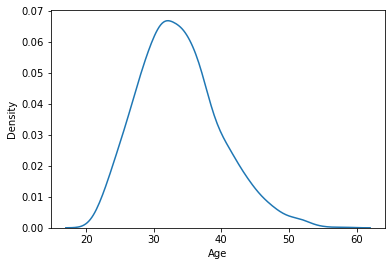

In [102]:
# Lets look at the distribution of "Age"
sns.histplot(data=dataset_train,x='Age',bins=30)
plt.show()

sns.kdeplot(data=dataset_train,x='Age')
plt.show()

# The distribution is little right skewed.
# We can use Transformation to try to make it Normally Distributed.

In [103]:
#Lets check the range of "Age" feature.
dataset_train['Age'].describe()

# We can use Log Transformation to try to make it Normally Distributed.

count    1839.000000
mean       33.764546
std         6.007660
min        21.000000
25%        29.000000
50%        33.000000
75%        37.000000
max        58.000000
Name: Age, dtype: float64

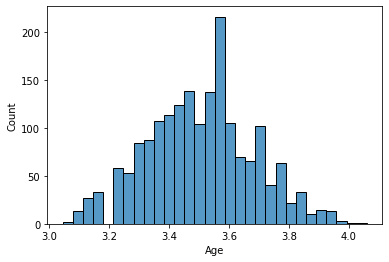

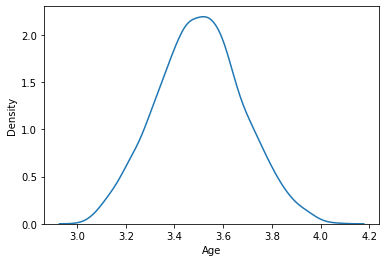

In [104]:
sns.histplot(np.log(dataset_train['Age']),bins=30)
plt.show()

sns.kdeplot(np.log(dataset_train['Age']))
plt.show()

# After doing Log Transformation, we get a distribution which is almost Normally Distributed.
# We can use Log transformation on "Age" feature.

In [105]:
# Transforming the "Income" column
dataset_train['Age']=np.log(dataset_train['Age'])
dataset_test['Age']=np.log(dataset_test['Age'])

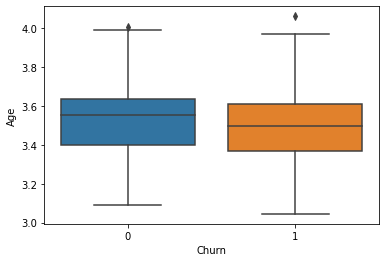

In [106]:
# Relationship of Income with Churn 
sns.boxplot(data=dataset_train,x='Churn',y='Age')
plt.show()
# For people who Churn, the median Age is lower.

### Gender

0.0    58.4
1.0    41.6
Name: Gender, dtype: float64


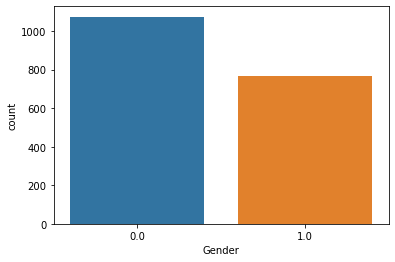

In [107]:
# Lets look at the frequecies of the difference categories of "Gender".
print(round(dataset_train['Gender'].value_counts(normalize=True)*100,2))
sns.countplot(dataset_train['Gender'])
plt.show()

# Gender-1 signifies that the driver is a female. Female:Male = 60:40

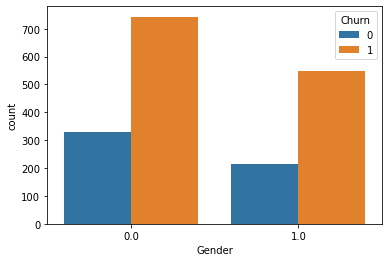

Gender,0.0,1.0
Churn,,
0,0.308194,0.281046
1,0.691806,0.718954


In [108]:
# Relationship of Gender with Churn 

sns.countplot(data=dataset_train,hue='Churn',x='Gender')
plt.show()

# The ratio of churn to non-churn is little different for different Genders.

pd.crosstab(dataset_train['Churn'],dataset_train['Gender'],normalize='columns')

### Joining Designation

1    43.39
2    33.82
3    20.83
4     1.52
5     0.44
Name: Joining Designation, dtype: float64


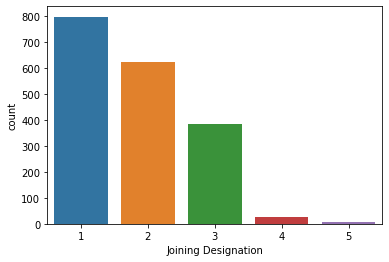

In [109]:
# Lets check the frequency counts of the different categories of "Joining Designation" feature.
print(round(100*dataset_train['Joining Designation'].value_counts(normalize=True),2))
sns.countplot(dataset_train['Joining Designation'])
plt.show()

# Most drivers had joined at designations - 1 and 2.

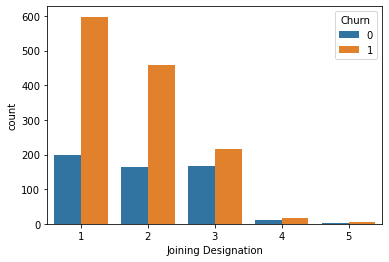

Joining Designation,1,2,3,4,5
Churn,,,,,
0,0.250627,0.263666,0.438642,0.428571,0.25
1,0.749373,0.736334,0.561358,0.571429,0.75


In [110]:
# Relationship of Joining_Designation with Churn 

sns.countplot(data=dataset_train,hue='Churn',x='Joining Designation')
plt.show()

# The ratio of churn to non-churn is different for different Joining Designations.

pd.crosstab(dataset_train['Churn'],dataset_train['Joining Designation'],normalize='columns')

### Grade

2    35.94
1    30.94
3    26.54
4     5.49
5     1.09
Name: Grade, dtype: float64


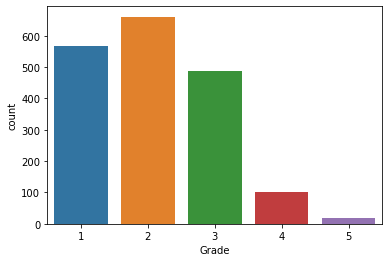

In [111]:
# Lets check the frequency counts of the different categories of "Grade" feature.
print(round(100*dataset_train['Grade'].value_counts(normalize=True),2))
sns.countplot(dataset_train['Grade'])
plt.show()

# Most drivers have current Grade as - 1,2 and 3.

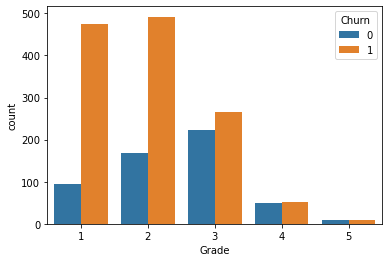

Grade,1,2,3,4,5
Churn,,,,,
0,0.165202,0.255673,0.456967,0.49505,0.5
1,0.834798,0.744327,0.543033,0.50495,0.5


In [112]:
# Relationship of Grade with Churn 

sns.countplot(data=dataset_train,hue='Churn',x='Grade')
plt.show()

# The ratio of churn to non-churn is different for different Grades.

pd.crosstab(dataset_train['Churn'],dataset_train['Grade'],normalize='columns')

### Quarterly_Rating_Flag

0    84.94
1    15.06
Name: Quarterly_Rating_Flag, dtype: float64


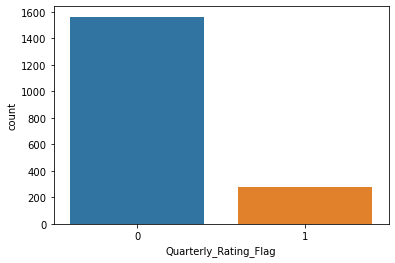

In [113]:
# Lets check the frequency counts of the different categories of "Quarterly Rating" feature.
print(round(100*dataset_train['Quarterly_Rating_Flag'].value_counts(normalize=True),2))
sns.countplot(dataset_train['Quarterly_Rating_Flag'])
plt.show()

# Most drivers have current Grade as - 1,2 and 3.

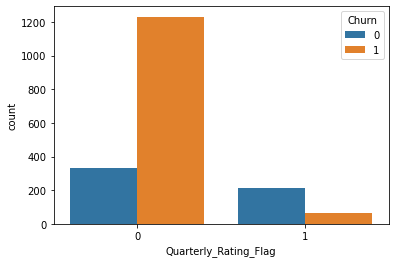

Quarterly_Rating_Flag,0,1
Churn,,
0,0.211908,0.776173
1,0.788092,0.223827


In [114]:
# Relationship of Quarterly_Rating_Flag with Churn 

sns.countplot(data=dataset_train,hue='Churn',x='Quarterly_Rating_Flag')
plt.show()

# The ratio of churn to non-churn is different for different Quarterly_Rating_Flags.

pd.crosstab(dataset_train['Churn'],dataset_train['Quarterly_Rating_Flag'],normalize='columns')

## Splitting into X and Y

In [115]:
# Firstly lets drop the "Driver_ID" column
dataset_train.drop(columns=['Driver_ID'],inplace=True)
dataset_test.drop(columns=['Driver_ID'],inplace=True)

In [116]:
# Splitting into X and Y
X_train=dataset_train.drop(columns=['Churn'])
Y_train=dataset_train['Churn']
X_test=dataset_test.drop(columns=['Churn'])
Y_test=dataset_test['Churn']

## Encoding

In [117]:
# Lets decide on which features to do Encoding.
X_train[categorical_columns].head()

# Only "City" feature need One Hot Encoding.

,City,Education_Level,Income_Flag,Gender,Joining Designation,Grade,Quarterly_Rating_Flag
731,C4,1,0,0.0,1,1,0
1793,C29,2,0,0.0,3,3,1
177,C6,2,0,1.0,3,3,0
28,C29,2,0,0.0,4,4,1
272,C9,0,0,1.0,2,2,0


## Creating Transformer

In [118]:
# Lets use a Transformer, for OneHotEncoding categorical columns and for Scaling Numerical Columns.

transformer=ColumnTransformer(transformers=[
    ('scaling',StandardScaler(),continuous_columns),
    ('one_hot_encoding',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'),['City'])
    ],remainder="passthrough")

In [119]:
# Transformed Data
X_train_transformed=transformer.fit_transform(X_train)
X_test_transformed=transformer.transform(X_test)

## Handling Imabalanced Data using SMOTE

In [120]:
# Getting Balanced Data using SMOTE.
smote_model=SMOTE(sampling_strategy='minority',random_state=42)
X_train_transformed_SMOTE,Y_train_SMOTE=smote_model.fit_resample(X_train_transformed,Y_train)

# Model 1 - Random Forests

In [121]:
# Creating a Random_Forest Model.
rf_model=RandomForestClassifier()

# Creating a parameters_list to do Hyperparameter Tuning
parameters = {
    'n_estimators': [15,20,25,30,35,40,45,50],
    'max_depth':[9,10,11,12,13,14]}

# Creating a Grid_Search Object
model=GridSearchCV(rf_model,parameters,scoring='accuracy',cv=5)
model.fit(X_train_transformed_SMOTE,Y_train_SMOTE)

print(model.best_params_)
print(model.best_score_)

{'max_depth': 14, 'n_estimators': 45}
0.887490198128496


In [122]:
# Using Grid_Search, the best accuracy that we are getting is 88.6 percent.

# Model 2 - XGBoost

In [123]:
# Creating a XGBoost Model.
xgb_model=XGBClassifier()

# Creating a parameters_list to do Hyperparameter Tuning
parameters = {
    'n_estimators': [15,20,25,30,35,40,45,50],
    'max_depth':[9,10,11,12,13,14],
    'learning_rate':[0.5,0.75,1]}

# Creating a Grid_Search Object
model=GridSearchCV(xgb_model,parameters,scoring='accuracy',cv=5)
model.fit(X_train_transformed_SMOTE,Y_train_SMOTE)

print(model.best_params_)
print(model.best_score_)

{'learning_rate': 0.5, 'max_depth': 14, 'n_estimators': 50}
0.8932891720125763


In [124]:
# Using Grid_Search, the best accuracy that we are getting is 89.3 percent.

In [125]:
#Since the XGBoost model has a better validation score, we can therefore use this model for determining the test_set accuracy

# Creating the final XGBoost model to find test dataset accuracy.
model=XGBClassifier(learning_rate= 0.5, max_depth= 14, n_estimators= 50)

#Fitting the model
model.fit(X_train_transformed_SMOTE,Y_train_SMOTE)

# Predicting Test Dataset Accuracy
print("Accuracy:",model.score(X_test_transformed,Y_test))
# The test dataset accuracy is 84.3 percent, which is a good score.

# Getting the Predictions
Y_pred=model.predict(X_test_transformed)

# Getting the probabilities.
Y_pred_prob=model.predict_proba(X_test_transformed)

Accuracy: 0.8434782608695652


In [126]:
# Getting the ROC_AUC Score.
roc_auc_score(Y_test,Y_pred_prob[:,1])

# A ROC_AUC score 0.88 is very good.

0.8788049987570903

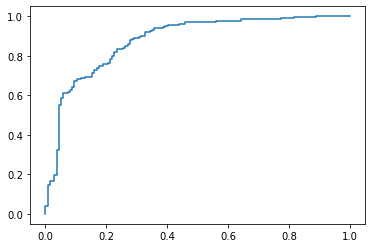

In [127]:
# ROC_AUC_Curve.
fpr,tpr,thres=roc_curve(Y_test,Y_pred_prob[:,1])
plt.plot(fpr,tpr)
plt.show()

# The curve is close to the ideal model curve

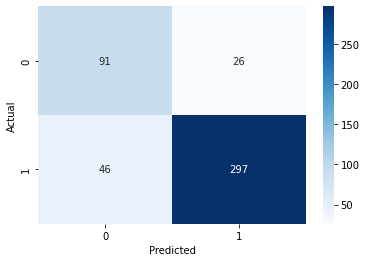

In [128]:
# Confusion Matrix
sns.heatmap(pd.crosstab(Y_pred,Y_test),annot=True,fmt='g',cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel("Actual")
plt.show()

## Insights & Recommendations
- Our XGBoost model has an accuracy of almost 85% and ROC_AUC score of almost 88%. Doing better prepreocessing and feature transformation, engineering might help increase the model's performance even further.
- Duration is an important feature to determine Churn. Drivers who stay longer have a lower chance of leaving Ola. Ola can give more salary or other perks to make drivers stay longer. Income is a very important feature to determine Churn. Drivers who have a lower income are more probable to Churn.
- Almost 90 percent of drivers who had got a raise from Ola did not Churn. This can be an important point where Ola can give incentives and lucrative hikes to retain their drivers.
- Most drivers who Churn are relatively younger than those who don’t. Ola can try to give certain goodies or hampers which can cater to the young drivers.
- Drivers who either join as Amateurs or as Highly Experienced have more chance of leaving. Ola can pay more to experienced drivers to earn their loyalty and can give lucrative incentives to young drivers to make them stay longer.
- Drivers with lower grades are more probable to Churn. Ola can increase their Grades after satisfactory performance to make drivers continue with Ola.
- Drivers whose Quarterly ratings had an increase had a 75 percent chance of not Churning. Therefore better hikes and ratings can also be an important factor to motivate drivers to continue with Ola.